<h1 style="text-align:center; font-size:180%; color:red;"> <b> MACHINE LEARNING TECHNIQUES FOR EEG DENOISING </b> </h1>
<div id="author"; style="text-align:center; font-size:150%;" > <b> Martina Doku </b> </div>
<div id="project"; style="text-align:center; font-size:100%;" > <b>  Bachelor Thesis in Applied Computer Science And Artificial Intelligence </b> </div>
<div id="year"; style="text-align:center; font-size:100%;" > <b>  2023 </b> </div>
<div id="university"; style="text-align:center; font-size:100%;" > <b>  University of Rome "La Sapienza"</b> </div>
<div id="supervisor"; style="text-align:center; font-size:100%;" > <b>  Prof. Danilo Avola </b> </div>



<h2 style=" font-size:150%; color:blue;"> <b> 1. Introduction </b> </h2>
<div id="abstract"> This notebook shows some Neural Network architectures for EEG artfact removal applied on the EEGdenoiseNet dataset</div>

In [206]:
#LIBRARIES:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import pywt
import math


<h2 style=" font-size:150%; color:blue;"> <b> 2. Dataset </b> </h2>
<div> First of all, let's introduce the dataset I am using, that is the EEGdenoiseNET, a dataset that contains pure EEG, EOG and EMG data. 
The dataset contains <b>4514 clean EEG segments</b> as ground truth, and <b>3400 pure electrooculography (EOG) segments</b> and <b>5598 pure electromyography (EMG) segments</b> as ocular artifacts and myogenic artifacts respectively. </div>

<h3 style=" font-size:100%; color:blue;"> <b> 2.1. Processing </b> </h3>
<div> The data was band-pass filtered between 1 and 80 Hz, notched at powerline frequency, and then re-sampled to 256 Hz. To obtain the clean EEG as ground truth, the 64-channel EEG signals were processed by ICLabel, a toolbox to remove EEG artifacts with independent component composition (ICA). For EOG and EMG the data preprocessing includes filtering, ICA-based artifacts removal, resampling, standardization, and visual checked by an expert. </div>


<h3 style=" font-size:100%; color:blue;"> <b> 2.2. Data structure </b> </h3>
<div> The dataset is composed by 3 folders: </div>
<ul>
    <li> <b>EEG</b>: contains the clean EEG signals </li>
    <li> <b>EOG</b>: contains the EOG signals </li>
    <li> <b>EMG</b>: contains the EMG signals </li>
</ul>
<div> Each folder contains 4514 files, each one containing a 1D array of 25600 values. </div>

<h3 style=" font-size:100%; color:blue;"> <b> 2.3. Data use </b> </h3>
<div>
This dataset was created as a benchmark for Deep Larning models, and it will be used in this project to:
<ol>
    <li> create samples of raw data </li>
    <li> perform denoising with different architectures </li>
    <li> test and validate our architectures </li>
</ol>
</div>


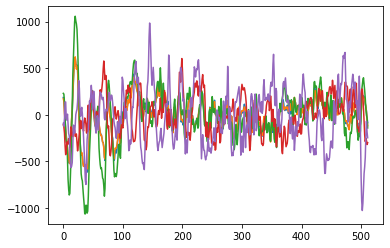

In [207]:
#PLOTTING 5 EEG PURE DATA
pure_EEG=np.load('data\EEG_all_epochs.npy')
#print(pure_EEG)
for i in pure_EEG[0:5]:
    plt.plot(range(len(i)),i)   #plotting 5 EEG pure data for all their length

5598


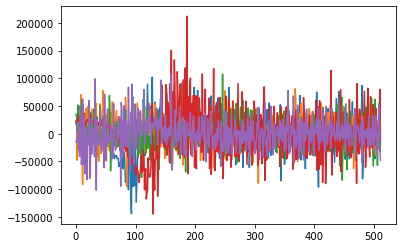

In [208]:
#PLOTTING 5 EMG PURE DATA
pure_EMG=np.load('data\EMG_all_epochs.npy')
#print(pure_EEG)
for i in pure_EMG[0:5]:
    plt.plot(range(len(i)),i)
print(len(pure_EMG))

3400


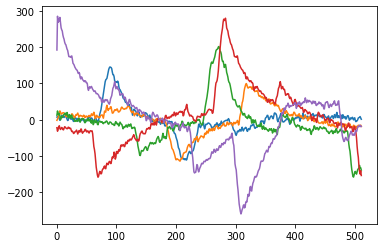

In [209]:
#PLOTTING 5 EOG PURE DATA
pure_EOG=np.load('data\EOG_all_epochs.npy')
#print(pure_EEG)
for i in pure_EOG[0:5]:
    plt.plot(range(len(i)),i)
print(len(pure_EOG))

<h2 style=" font-size:150%; color:blue;"> <b> 3. Data preparation </b> </h2>
<div> In this section I will prepare the data to be used in the models.Specifically, we are going to create a dataset composed of:
<ol>
    <li> <b>EEG_raw_training_data</b>: 80% of the EEG signals </li>
    <li> <b>EEG_clean_training_data</b>: 80% of the clean EEG signals </li>
    <li> <b>EEG_raw_validation_data</b>: 10% of the EEG signals </li>
    <li> <b>EEG_clean_validation_data</b>: 10% of the clean EEG signals </li>
    <li> <b>EEG_raw_test_data</b>: 10% of the EEG signals </li>
    <li> <b>EEG_clean_test_data</b>: 10% of the clean EEG signals </li>  
</ol>
</div>
<div style="color:red" > <b> Note:</b> </div> <div> The process includes code from the <a href="https://github.com/ncclabsustech/EEGdenoiseNet">EEGdenoiseNet</a> repository. </div>


In [210]:
import sklearn.model_selection as ms
import numpy as np
import scipy.io as sio
import math
# Author: Haoming Zhang
#The code here not only include data importing, but also data standardization and the generation of analog noise signals


#PERFORMS THE STANDARD DEVIATION OF THE RECORDS
def get_std(records):
    return math.sqrt(sum([x ** 2 for x in records]) / len(records)) 


#AUGMENTS THE SIGNAL AND ADDS RANDOM DISTURB
def random_signal(signal,combin_num):   #signal= EEG data (?), combin_num= number of times we want to shuffle data (factor of which)
                                        #we want to augment our data
    random_result=[]

    for i in range(combin_num):
        random_num = np.random.permutation(signal.shape[0])     #creates a random shuffled list of integers from 0 to signal.shape[0]
        shuffled_dataset = signal[random_num,:]                #takes the elemnt of signal in the order we just shuffled
        shuffled_dataset = shuffled_dataset.reshape(signal.shape[0],signal.shape[1]) #reshapes it to have the sam eshap eof the original signal
        random_result.append(shuffled_dataset)                  #adds the shuffled signal to final result (we may want to repeat those steps to augment data)
    random_result  = np.array(random_result)

    return  random_result


#OBTAINING RAW DATA (training, validation and test)
def prepare_data(EEG_all, noise_all, combin_num, train_per, noise_type):    #EEG_all= original eeg data
                                                                            #noise_all= original noise data
                                                                            #combin_num= factor of which we wanto to augment data
                                                                            #train_per=percentage of data that we want to use as training [0,1]
                                                                            #noise_type= 'EMG' or 'EOG'

    EEG_all_random = np.squeeze(random_signal(signal = EEG_all, combin_num = 1))        #shuffling pure eeg
    noise_all_random = np.squeeze(random_signal(signal = noise_all, combin_num = 1))    #shuffling pure noise

    #If the noise type is EMG, EEG signal will be partially reused to match 'EMG signal' shape
    if noise_type == 'EMG':                  
        reuse_num = noise_all_random.shape[0] - EEG_all_random.shape[0] #we find the differenece of dimensions between EEG and EMG, n
        EEG_reuse = EEG_all_random[0 : reuse_num, :]                    #we select aportion of magnitude n from EEG
        EEG_all_random = np.vstack([EEG_reuse, EEG_all_random])         #stack original EEG  with that extra portion 
        print('EEG segments after reuse: ',EEG_all_random.shape[0])

    #If the noise type is EOG, EEG signal will be partially dropped to match 'EOG signal' shape
    elif noise_type == 'EOG':  
        EEG_all_random = EEG_all_random[0:noise_all_random.shape[0]]    #We drop some of the EEG signal to much the number of EMG
        print('EEG segments after drop: ',EEG_all_random.shape[0])


    #defining important data
    timepoint = noise_all_random.shape[1]                               #get the number of timestamps
    train_num = round(train_per * EEG_all_random.shape[0])              #the number of training points
    validation_num = round((EEG_all_random.shape[0] - train_num) / 2)   #the number of validation points
    test_num = EEG_all_random.shape[0] - train_num - validation_num     #the number of test points

    #splitting EEG in train,validation,test
    train_eeg = EEG_all_random[0 : train_num, :]
    validation_eeg = EEG_all_random[train_num : train_num + validation_num, :]
    test_eeg = EEG_all_random[train_num + validation_num : EEG_all_random.shape[0], :]

    #splittting EEG in train,validation,test
    train_noise = noise_all_random[0 : train_num, :]
    validation_noise = noise_all_random[train_num : train_num + validation_num,:]
    test_noise = noise_all_random[train_num + validation_num : noise_all_random.shape[0], :]

    #Augmenting training data and adding noise, with a factor of combin_num
    EEG_train = random_signal(signal = train_eeg, combin_num = combin_num).reshape(combin_num * train_eeg.shape[0], timepoint)
    NOISE_train = random_signal(signal = train_noise, combin_num = combin_num).reshape(combin_num * train_noise.shape[0], timepoint)

    #################################  simulate noise signal of training set  ##############################

    #creating random number between -10dB ~ 2dB
    SNR_train_dB = np.random.uniform(-7, 2, (EEG_train.shape[0]))   #samples randomly as many point as the ones in training set
    print(SNR_train_dB.shape)                                       #from the uniform distribution from -7 to 2
    SNR_train = 10 ** (0.1 * (SNR_train_dB))

    #combining eeg and noise for training set 
    noiseEEG_train=[]
    NOISE_train_adjust=[]
    for i in range (EEG_train.shape[0]):
        eeg=EEG_train[i].reshape(EEG_train.shape[1])        #for each sample reates a vector of EEG data
        noise=NOISE_train[i].reshape(NOISE_train.shape[1])  #and a vector of noise data

        coe=get_std(eeg)/(get_std(noise)*SNR_train[i])      #computes a mixing coefficient as the std of eeg divided by 
                                                            #the std of noise multiplied by the SNR (random noise?)
        noise = noise*coe           #multiply the noise by the coefficient
        neeg = noise+eeg            #add it to clean eeg to obtain raw data

        NOISE_train_adjust.append(noise)
        noiseEEG_train.append(neeg)

    noiseEEG_train=np.array(noiseEEG_train)                 #create an array with raw train EEg
    NOISE_train_adjust=np.array(NOISE_train_adjust)         #create an array with the noise we added to the pure eeg

    #dividing each epoch of training data (both raw and clean) for standard deviation
    EEG_train_end_standard = []
    noiseEEG_train_end_standard = []

    for i in range(noiseEEG_train.shape[0]):
        eeg_train_all_std = EEG_train[i] / np.std(noiseEEG_train[i])
        EEG_train_end_standard.append(eeg_train_all_std)

        noiseeeg_train_end_standard = noiseEEG_train[i] / np.std(noiseEEG_train[i])
        noiseEEG_train_end_standard.append(noiseeeg_train_end_standard)

    noiseEEG_train_end_standard = np.array(noiseEEG_train_end_standard)
    EEG_train_end_standard = np.array(EEG_train_end_standard)
    print('training data prepared', noiseEEG_train_end_standard.shape, EEG_train_end_standard.shape )

    #################################  simulate noise signal of validation  ##############################

    SNR_val_dB = np.linspace(-7.0, 2.0, num=(10))
    SNR_val = 10 ** (0.1 * (SNR_val_dB))

    eeg_val = np.array(validation_eeg)
    noise_val = np.array(validation_noise)
    
    # combin eeg and noise for test set 
    EEG_val = []
    noise_EEG_val = []
    for i in range(10):
        
        noise_eeg_val = []
        for j in range(eeg_val.shape[0]):
            eeg = eeg_val[j]
            noise = noise_val[j]
            
            coe = get_std(eeg) / (get_std(noise) * SNR_val[i])
            noise = noise * coe
            neeg = noise + eeg
            
            noise_eeg_val.append(neeg)
        
        EEG_val.extend(eeg_val)
        noise_EEG_val.extend(noise_eeg_val)


    noise_EEG_val = np.array(noise_EEG_val)
    EEG_val = np.array(EEG_val)


    # std for noisy EEG
    EEG_val_end_standard = []
    noiseEEG_val_end_standard = []
    # std_VALUE = []
    for i in range(noise_EEG_val.shape[0]):
        
        # store std value to restore EEG signal
        std_value = np.std(noise_EEG_val[i])
        #std_VALUE.append(std_value)

        # Each epochs of eeg and neeg was divide by the standard deviation
        eeg_val_all_std = EEG_val[i] / std_value
        EEG_val_end_standard.append(eeg_val_all_std)

        noiseeeg_val_end_standard = noise_EEG_val[i] / std_value
        noiseEEG_val_end_standard.append(noiseeeg_val_end_standard)

    #std_VALUE = np.array(std_VALUE)
    noiseEEG_val_end_standard = np.array(noiseEEG_val_end_standard)
    EEG_val_end_standard = np.array(EEG_val_end_standard)
    print('validation data prepared, validation data shape: ', noiseEEG_val_end_standard.shape, EEG_val_end_standard.shape)

    #################################  simulate noise signal of test  ##############################

    SNR_test_dB = np.linspace(-7.0, 2.0, num=(10))
    SNR_test = 10 ** (0.1 * (SNR_test_dB))

    eeg_test = np.array(test_eeg)
    noise_test = np.array(test_noise)
    
    # combin eeg and noise for test set 
    EEG_test = []
    noise_EEG_test = []
    for i in range(10):
        
        noise_eeg_test = []
        for j in range(eeg_test.shape[0]):
            eeg = eeg_test[j]
            noise = noise_test[j]
            
            coe = get_std(eeg) / (get_std(noise) * SNR_test[i])
            noise = noise * coe
            neeg = noise + eeg
            
            noise_eeg_test.append(neeg)
        
        EEG_test.extend(eeg_test)
        noise_EEG_test.extend(noise_eeg_test)


    noise_EEG_test = np.array(noise_EEG_test)
    EEG_test = np.array(EEG_test)


    # std for noisy EEG
    EEG_test_end_standard = []
    noiseEEG_test_end_standard = []
    std_VALUE = []
    for i in range(noise_EEG_test.shape[0]):
        
        # store std value to restore EEG signal
        std_value = np.std(noise_EEG_test[i])
        std_VALUE.append(std_value)

        # Each epochs of eeg and neeg was divide by the standard deviation
        eeg_test_all_std = EEG_test[i] / std_value
        EEG_test_end_standard.append(eeg_test_all_std)

        noiseeeg_test_end_standard = noise_EEG_test[i] / std_value
        noiseEEG_test_end_standard.append(noiseeeg_test_end_standard)

    std_VALUE = np.array(std_VALUE)
    noiseEEG_test_end_standard = np.array(noiseEEG_test_end_standard)
    EEG_test_end_standard = np.array(EEG_test_end_standard)
    print('test data prepared, test data shape: ', noiseEEG_test_end_standard.shape, EEG_test_end_standard.shape)

    return noiseEEG_train_end_standard, EEG_train_end_standard, noiseEEG_val_end_standard, EEG_val_end_standard, noiseEEG_test_end_standard, EEG_test_end_standard, std_VALUE

Let's effectively build the dataset:

In [211]:
#CREATING THE WHOLE TRAING VALIDATION AND TEST DATABASE
#for each pure EEG we are going to select 100 pure EMG and 100 pure EOG and obtained resulting raw data
#at the end we will have 4514*200 tuples of(raw_eeg_train, clean_eeg_train, raw_eeg_val, clean_eeg_val, raw_eeg_test, clean_eeg_test)
train_dataset=[[],[]]
validation_dataset=[[],[]]
test_dataset=[[],[]]
#for element in pure_EEG:
#combining the EEG with 100 random EMG
#for i in np.random.randint(0,len(pure_EMG),100):
noiseEEG_train, EEG_train, noiseEEG_val, EEG_val, noiseEEG_test, EEG_test, test_std_VALUE = prepare_data(EEG_all = pure_EEG, noise_all = pure_EMG, combin_num = 10, train_per = 0.8, noise_type = 'EMG')
train_dataset[0]=noiseEEG_train
train_dataset[1]=EEG_train
validation_dataset[0]=noiseEEG_val
validation_dataset[1]=EEG_val
test_dataset[0]=noiseEEG_test
test_dataset[1]=EEG_test

#combining the EEG with 100 random EOG
#for i in np.random(0,len(pure_EOG),100):
noiseEEG_train, EEG_train, noiseEEG_val, EEG_val, noiseEEG_test, EEG_test, test_std_VALUE = prepare_data (EEG_all = pure_EEG, noise_all = pure_EOG, combin_num = 10, train_per = 0.8, noise_type = 'EOG')
train_dataset[0]=np.vstack((train_dataset[0],noiseEEG_train))
train_dataset[1]=np.vstack((train_dataset[1],EEG_train))
validation_dataset[0]=np.vstack((validation_dataset[0],noiseEEG_val))
validation_dataset[1]=np.vstack((validation_dataset[1],EEG_val))
test_dataset[0]=np.vstack((test_dataset[0],noiseEEG_test))
test_dataset[1]=np.vstack((test_dataset[1],EEG_test))

print('the number of total (EMG and EOG noise added) training saples is',len(train_dataset[0]))

EEG segments after reuse:  5598
(44780,)
training data prepared (44780, 512) (44780, 512)
validation data prepared, validation data shape:  (5600, 512) (5600, 512)
test data prepared, test data shape:  (5600, 512) (5600, 512)
EEG segments after drop:  3400
(27200,)
training data prepared (27200, 512) (27200, 512)
validation data prepared, validation data shape:  (3400, 512) (3400, 512)
test data prepared, test data shape:  (3400, 512) (3400, 512)
the number of total (EMG and EOG noise added) training saples is 71980


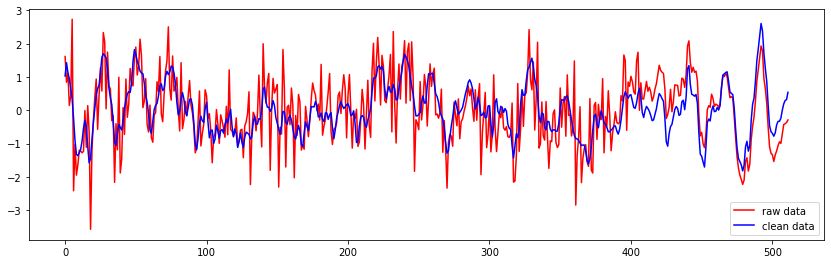

In [212]:
#VISUALIZIND RAW AND PURE EEG DATA (1 example)
fig, ax = plt.subplots()
fig.set_size_inches(14.25, 4.25)
ax.plot(range(len(train_dataset[0][0])),train_dataset[0][0],color='red',label='raw data')
ax.plot(range(len(train_dataset[1][0])),train_dataset[1][0],color='blue',label='clean data')
ax.legend()

<h2 style=" font-size:150%; color:blue;"> <b> 4.Fast Fourier Transform </b> </h2>
<div> This section shows the results of the FFT applied on the EEG signals. </div>

c:\Users\user\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


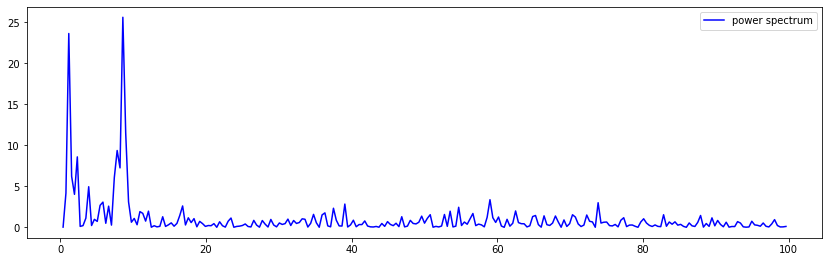

In [213]:
#performing fast fourier transform on the raw EEG data
dt=1/200                                #sampling rate
t=range(len(train_dataset[0][0]))       #time
n=len(t)                                #number of samples
fft=np.fft.fft(train_dataset[0][0],n)   #fourier transform
PSD=fft*np.conj(fft)/n                  #power spectrum
freq=(1/(dt*n))*np.arange(n)            #frequency
L=np.arange(1,np.floor(n/2),dtype='int')    #only plot the first half of the spectrum

#PLOTTING THE POWER SPECTRUM
fig, ax = plt.subplots()
fig.set_size_inches(14.25, 4.25)
ax.plot(freq[L],PSD[L],color='blue',label='power spectrum')
ax.legend()




c:\Users\user\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\user\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\user\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


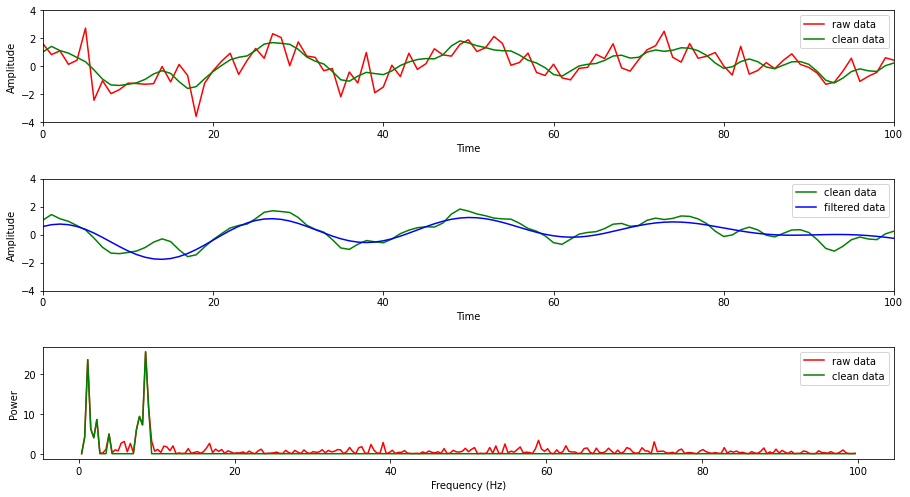

In [214]:
#CREATING A FILTER TO REMOVE THE NOISE
indices= PSD>4          #creaes a boolean array with true values where PSD>4 (the vlue has been chosen from the max values in the power spectrum)
PSDclean=PSD*indices    #removes the noise from the power spectrum
fft=indices*fft         #removes the noise from the fourier transform
ffilt=np.fft.ifft(fft)  #inverse fourier transform

#PLOTTING:
#1) THE RAW VS CLEAN EEG DATA
#2) THE CLEAN VS FILTERED EEG DATA
#3) THE POWER SPECTRUM OF THE RAW EEG DATA VS THE CLEAN EEG DATA
fig, ax = plt.subplots(3,1)
fig.subplots_adjust(hspace=0.5)
fig.set_size_inches(15.25, 8.25)

ax[0].set_xlim(0,100)
ax[0].set_ylim(-4,4)
ax[0].plot(t,train_dataset[0][0], color='red', label='raw data')
ax[0].plot(t,train_dataset[1][0], color='green',label='clean data')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')
ax[0].legend(loc='upper right')

ax[1].set_xlim(0,100)
ax[1].set_ylim(-4,4)
ax[1].plot(t,train_dataset[1][0], color='green',label='clean data')
ax[1].plot(t,ffilt, color='blue', label='filtered data')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Amplitude')
ax[1].legend()

ax[2].plot(freq[L],PSD[L], color='red', label='raw data')
ax[2].plot(freq[L],PSDclean[L], color='green',label='clean data')
ax[2].set_xlabel('Frequency (Hz)')
ax[2].set_ylabel('Power')
ax[2].legend()

<h2 style=" font-size:150%; color:blue;"> <b> 5. Short time Fourier Transform </b> </h2>
<div> This section shows the results of the STFT applied on the EEG signals. </div>
we first define the signal as a function of time t. We then define the parameters of the STFT, including the length of each window window_length, the overlap between windows overlap, and the size of the FFT fft_size. We compute the STFT using the stft function from scipy.signal, which returns the complex-valued STFT coefficients as a function of frequency f and time t. We apply thresholding to the STFT coefficients using the np.where function, which sets coefficients below a certain threshold to zero. We then reconstruct the signal using the inverse STFT using the istft function from scipy.signal. Finally, we plot the original signal and the denoised signal using matplotlib.

You can adjust the STFT parameters and the threshold value according to your requirements. Note that the stft function also takes additional arguments to control the windowing function, such as the parameter window to specify the type of window and the parameter nperseg to specify the length of each segment.

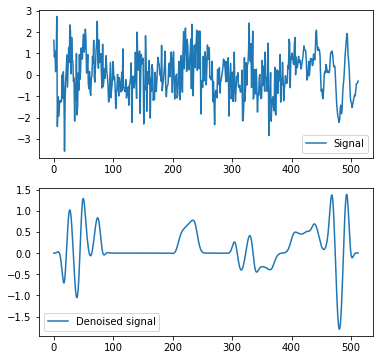

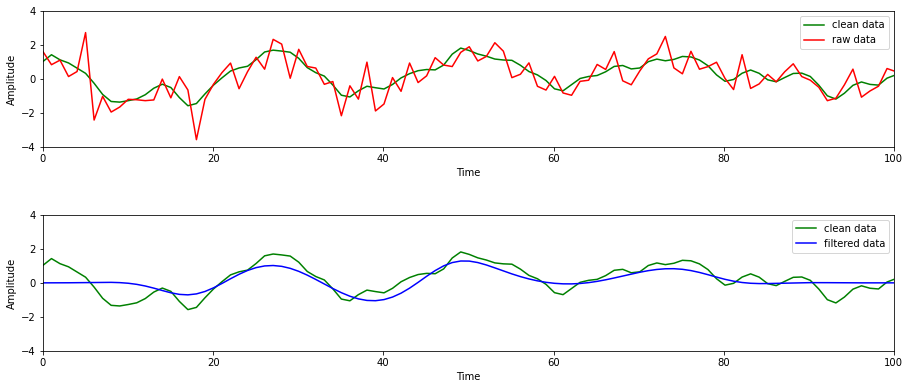

In [218]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Define the signal
signal_=train_dataset[0][0]
t=np.linspace(0, len(signal_), len(signal_))

# Define the STFT parameters
window_length = 64 # length of each window
overlap = int(window_length/2) # overlap between windows
fft_size = 128 # size of the FFT

# Compute the STFT
f, t_, Zxx = signal.stft(signal_, fs=1.0, window='hann', nperseg=window_length, noverlap=overlap, nfft=fft_size)

# Apply thresholding to the STFT coefficients
threshold = 0.5
Zxx = np.where(np.abs(Zxx) > threshold * np.max(np.abs(Zxx)), Zxx, 0)

# Reconstruct the signal using the inverse STFT
_, signal_denoised = signal.istft(Zxx, fs=1.0, window='hann', nperseg=window_length, noverlap=overlap, nfft=fft_size)

# Plot the results
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(6, 6))
ax0.plot(t, signal_, label='Signal')
ax0.legend()
ax1.plot(t, signal_denoised, label='Denoised signal')
ax1.legend()
plt.show()

#PLOTTING:
#1) THE RAW VS CLEAN EEG DATA
#2) THE CLEAN VS FILTERED EEG DATA
fig, ax = plt.subplots(2,1)
fig.subplots_adjust(hspace=0.5)
fig.set_size_inches(15.25, 6.25)

ax[0].set_xlim(0,100)
ax[0].set_ylim(-4,4)
ax[0].plot(t,train_dataset[1][0], color='green',label='clean data')
ax[0].plot(t,train_dataset[0][0], color='red', label='raw data')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')
ax[0].legend(loc='upper right')

ax[1].set_xlim(0,100)
ax[1].set_ylim(-4,4)
ax[1].plot(t,train_dataset[1][0], color='green',label='clean data')
ax[1].plot(t,signal_denoised, color='blue', label='filtered data')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Amplitude')
ax[1].legend(loc='upper right')




<h2 style=" font-size:150%; color:blue;"> <b> Wiegner Ville Distribution </b> </h2><div> This section shows the results of the WVD applied on the EEG signals. </div>


In [223]:
# Define the signal
signal_=train_dataset[0][0]
t=np.linspace(0, len(signal_), len(signal_))


# Compute the WVT
Zxx = signal.wigner_ville(signal_, fs=1.0, nfft=1024)

# Apply thresholding to the WVT coefficients
threshold = 0.5
Zxx = np.where(np.abs(Zxx) > threshold * np.max(np.abs(Zxx)), Zxx, 0)

# Reconstruct the signal using the inverse WVT
signal_denoised = signal.invwigner_ville(Zxx, signal_.size)

# Plot the results
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(6, 6))
ax0.plot(t, signal_, label='Signal')
ax0.legend()
ax1.plot(t, signal_denoised, label='Denoised signal')
ax1.legend()
plt.show()

ax[0].set_ylim(-4,4)
ax[0].plot(t,train_dataset[1][0], color='green',label='clean data')
ax[0].plot(t,train_dataset[0][0], color='red', label='raw data')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')
ax[0].legend(loc='upper right')


ax[1].set_ylim(-4,4)
ax[1].plot(t,train_dataset[1][0], color='green',label='clean data')
ax[1].plot(t,signal_denoised, color='blue', label='filtered data')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Amplitude')
ax[1].legend(loc='upper right')



AttributeError: module 'scipy.signal' has no attribute 'wigner_ville'

<h2 style=" font-size:150%; color:blue;"> <b> Wavelet transform </b> </h2><div> This section shows the results of the WT applied on the EEG signals. </div>

ValueError: operands could not be broadcast together with shapes (512,) (1000,) 

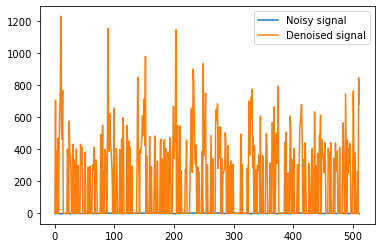

In [ ]:
#RAW SIGNAL
x=train_dataset[0][0]

#MORLET WAVE
f=

